### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Dataset

In [2]:
EXPERIMENT = "tara"
ACTIVITIES = ["relaxing", "eating", "walking", "studying"]
dataset: pd.DataFrame = pd.read_csv(f"datasets/{EXPERIMENT}.csv")
dataset.columns.values[0] = "time"
print(dataset.columns)
dataset

Index(['time', 'accel_z', 'accel_y', 'accel_x', 'gyro_z', 'gyro_y', 'gyro_x',
       'gravity_z', 'gravity_y', 'gravity_x', 'ori_qz', 'ori_qy', 'ori_qx',
       'ori_qw', 'magne_z', 'magne_y', 'magne_x', 'bar_relativeAltitude',
       'bar_pressure', 'gps_altitude', 'gps_latitude', 'gps_longitude',
       'relaxing', 'eating', 'walking', 'studying'],
      dtype='object')


,time,accel_z,accel_y,accel_x,gyro_z,gyro_y,gyro_x,gravity_z,gravity_y,gravity_x,...,magne_x,bar_relativeAltitude,bar_pressure,gps_altitude,gps_latitude,gps_longitude,relaxing,eating,walking,studying
0,2023-06-08 10:02:14.428471800,-0.004068,0.033979,-0.027080,-0.051672,0.075464,-0.011046,-7.343450,-6.471474,-0.457445,...,4.546346,-0.042274,1017.524719,41.925382,52.045397,4.384513,0,0,0,0
1,2023-06-08 10:02:15.428471800,0.046718,-0.051833,0.007038,0.005975,-0.041301,0.006421,-7.587952,-6.207840,-0.224354,...,5.082871,-0.084553,1017.529984,41.930438,52.045389,4.384509,0,0,0,0
2,2023-06-08 10:02:16.428471800,0.258378,0.015733,-0.086734,0.292964,0.487526,-0.174606,-7.115600,-6.463938,-1.046507,...,10.147813,-0.084553,1017.529984,41.877450,52.045384,4.384505,0,0,0,0
3,2023-06-08 10:02:17.428471800,-0.388019,-0.656673,0.409764,-0.058768,0.024429,-0.334667,-9.386129,-2.428225,0.830423,...,18.734642,-0.031708,1017.523575,41.843560,52.045386,4.384503,0,0,0,0
4,2023-06-08 10:02:18.428471800,0.181126,0.652100,0.148817,-0.114041,-0.001110,0.078117,-9.671041,-1.264088,-0.085595,...,13.000465,0.155897,1017.500992,41.886054,52.045386,4.384501,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21599,2023-06-08 16:02:13.428471800,-0.021761,0.002616,0.002799,0.000822,-0.002059,0.015809,0.609068,-9.656272,-1.598371,...,11.238202,20.419849,1015.060806,41.477542,52.045441,4.384580,1,0,0,0
21600,2023-06-08 16:02:14.428471800,0.014316,0.002327,-0.003718,0.014287,0.011617,0.026606,0.848866,-9.622351,-1.686895,...,10.879721,20.430418,1015.059662,41.477542,52.045441,4.384580,1,0,0,0
21601,2023-06-08 16:02:15.428471800,0.009734,0.003723,-0.005396,-0.012023,-0.035512,0.037696,1.123775,-9.595271,-1.669564,...,10.876070,NaN,NaN,41.486357,52.045444,4.384573,1,0,0,0
21602,2023-06-08 16:02:16.428471800,-0.001886,0.009764,0.005781,-0.012753,-0.005079,-0.044107,1.032805,-9.629271,-1.538645,...,11.351871,NaN,NaN,NaN,NaN,NaN,1,0,0,0


### Visualization

#### Overview

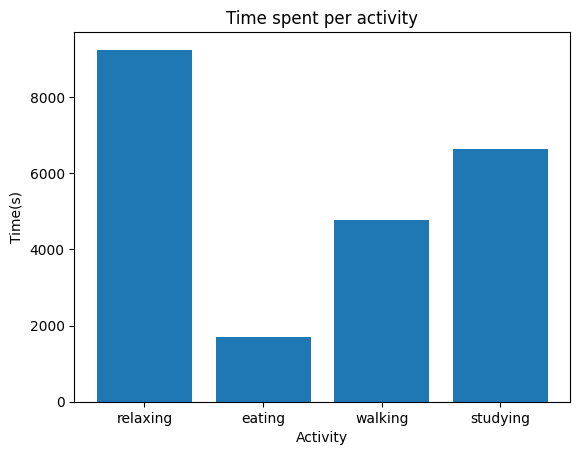

In [3]:
activities_count: pd.DataFrame = pd.DataFrame(
    dataset[ACTIVITIES].sum(),
    columns=['Sum']
)

plt.bar(activities_count.index, activities_count['Sum'])
plt.xlabel('Activity')
plt.ylabel('Time(s)')
plt.title('Time spent per activity')
plt.show()

#### Accelerometer

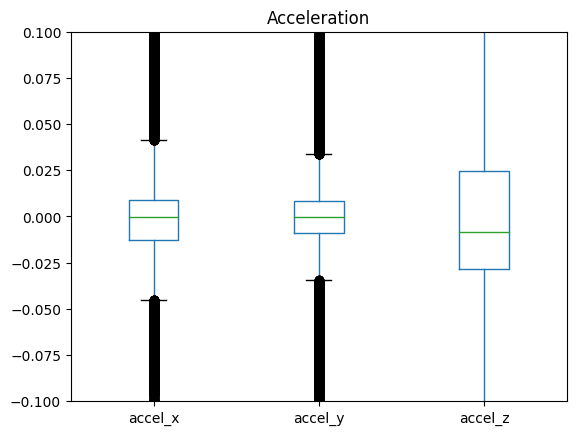

In [4]:
plt.Figure()
dataset[['accel_x', 'accel_y', 'accel_z']].plot.box()
plt.ylim([-0.1, 0.1])
plt.title("Acceleration")
plt.show()

#### Gravity

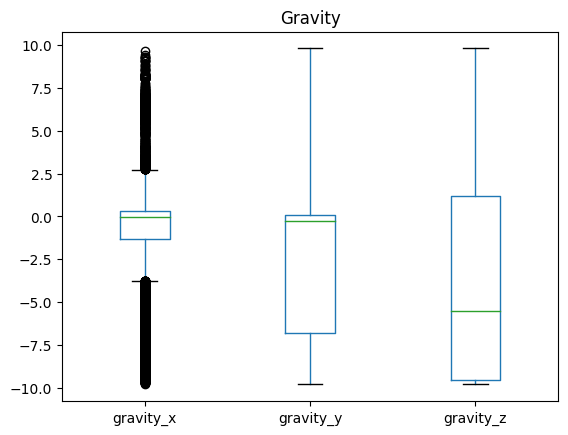

In [5]:
plt.Figure()
dataset[['gravity_x', 'gravity_y', 'gravity_z']].plot.box()

plt.title("Gravity")
plt.show()

#### Gyroscope

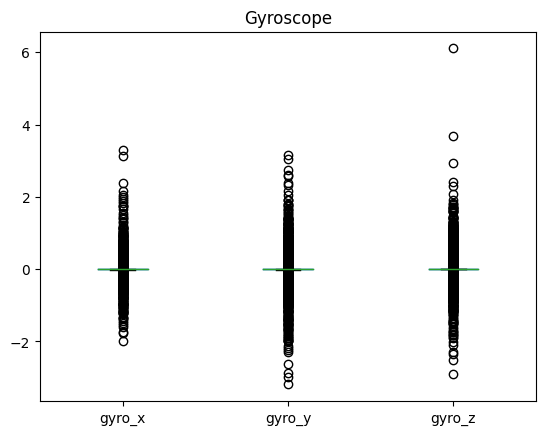

In [6]:
plt.Figure()
dataset[['gyro_x', 'gyro_y', 'gyro_z']].plot.box()

plt.title("Gyroscope")
plt.show()

#### Orientation

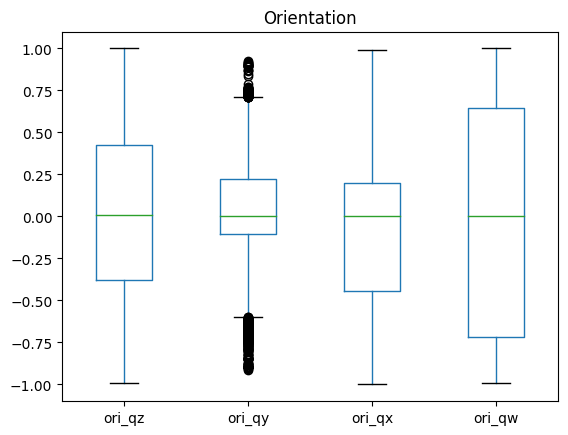

In [7]:
plt.Figure()
dataset[["ori_qz", "ori_qy", "ori_qx", "ori_qw"]].plot.box()
plt.title("Orientation")
plt.show()

#### Magnetometer

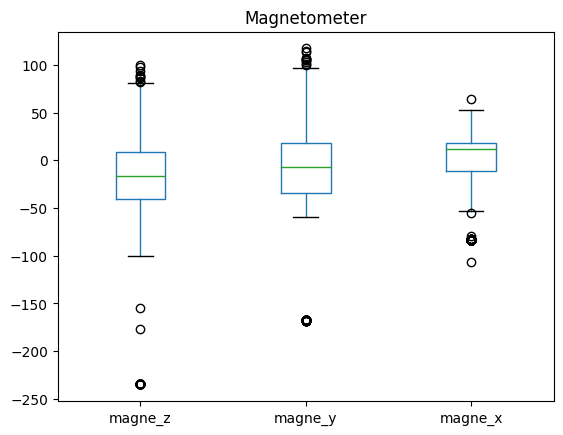

In [8]:
plt.Figure()
dataset[["magne_z", "magne_y", "magne_x"]].plot.box()
plt.title("Magnetometer")
plt.show()

#### Barometer

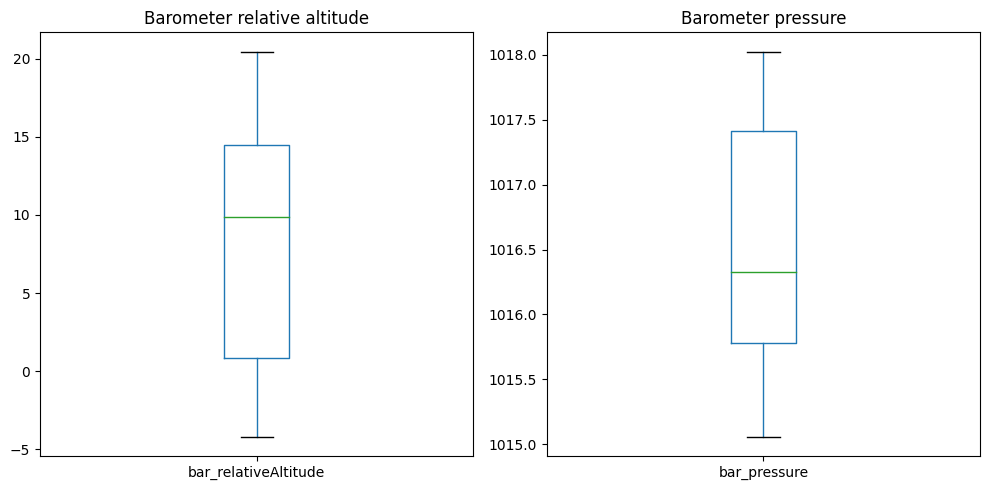

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dataset[["bar_relativeAltitude"]].plot.box(ax=axes[0])
axes[0].set_title("Barometer relative altitude")

dataset[["bar_pressure"]].plot.box(ax=axes[1])
axes[1].set_title("Barometer pressure")

plt.tight_layout()
plt.show()

#### Location

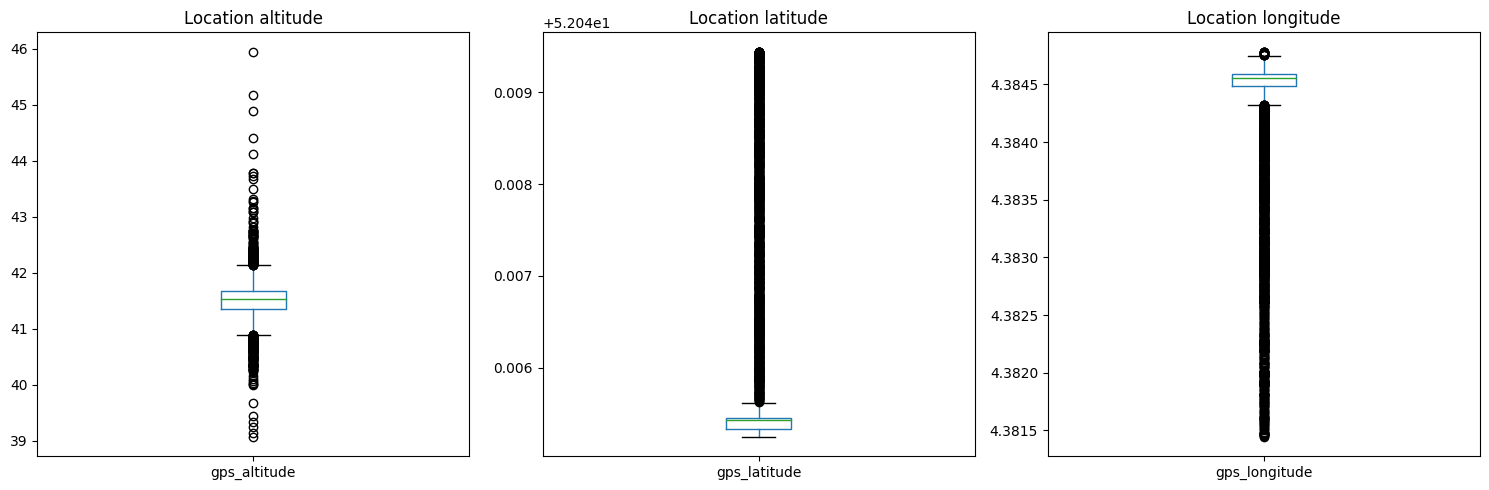

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

dataset[["gps_altitude"]].plot.box(ax=axes[0])
axes[0].set_title("Location altitude")

dataset[["gps_latitude"]].plot.box(ax=axes[1])
axes[1].set_title("Location latitude")

dataset[["gps_longitude"]].plot.box(ax=axes[2])
axes[2].set_title("Location longitude")

plt.tight_layout()
plt.show()

### Outlier removal

In [11]:
def print_missing_values_percentages(dataset: pd.DataFrame):
    nan_percentages_per_column = []
    for column in dataset.columns:
        
        nan_values = dataset[column].isnull().sum()
        
        total_values = dataset.shape[0]
        
        percentages = (nan_values / total_values) * 100
        
        nan_percentages_per_column.append(
            percentages
        )

    sns.barplot(y=nan_percentages_per_column, x=dataset.columns)
    plt.xticks(rotation=90, size=6)
    plt.tight_layout()
    plt.show()

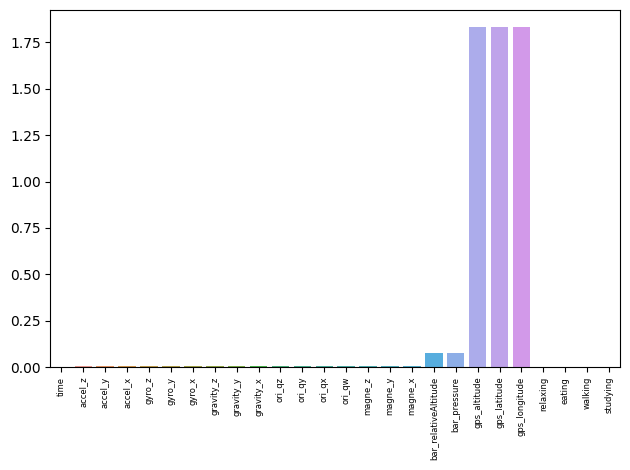

In [12]:
print_missing_values_percentages(dataset)

In [18]:
from book.Chapter3.OutlierDetection import DistanceBasedOutlierDetection

outlier_removal_columns = [
    'accel_z', 'accel_y', 'accel_x',
    'gyro_z', 'gyro_y', 'gyro_x',
    'magne_z', 'magne_y', 'magne_x',
]

d_min = 0.1
f_min = 0.99

OutlierDist = DistanceBasedOutlierDetection()
for col in outlier_removal_columns:
    try:
        dataset = OutlierDist.simple_distance_based(
            dataset, [col], 'euclidean', d_min, f_min)
        dataset.loc[dataset['simple_dist_outlier'] == True, col] = None
    except MemoryError as e:
        print(
            'Not enough memory available for simple distance-based outlier detection...')
        print('Skipping.')
dataset = dataset.drop('simple_dist_outlier', axis=1)

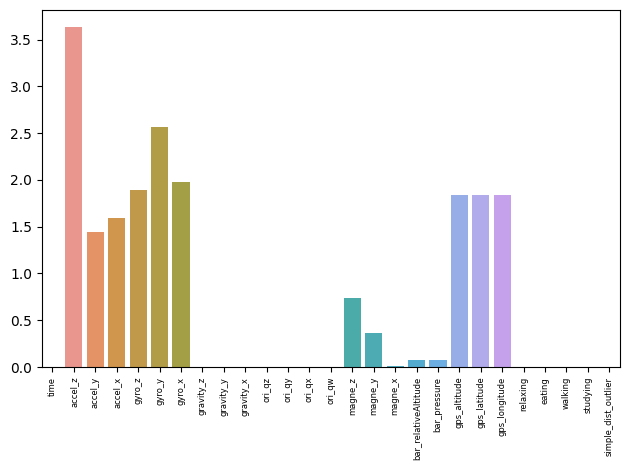

In [15]:
print_missing_values_percentages(dataset)

### Data inputation

In [16]:
dataset = dataset.interpolate(method='linear')

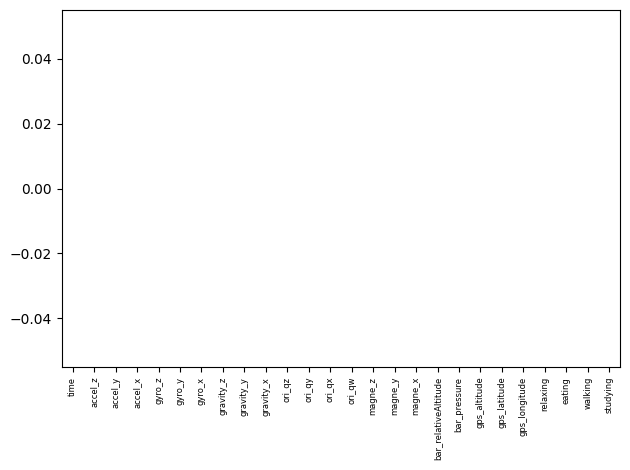

In [19]:
print_missing_values_percentages(dataset)